In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import random
import tensorflow as tf
import time
import numpy as np
from tqdm import tqdm
from vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge,Input
from sklearn.utils import shuffle
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


Add Google drive
Add vgg16.py
Add imagenet_utils.py 

In [ ]:
seed = 80
np.random.seed = seed
# original shape = 512x512
NAME = "classification_1-{}".format(int(time.time()))

TRAINING_DIR = "/content/drive/My Drive/COVID_PENUMONIA_CLASSIFICATION/Dataset/"

data_dir_list = os.listdir(TRAINING_DIR)


Preprocessing

In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = os.listdir(TRAINING_DIR+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    for img in tqdm(img_list):
        img_path = TRAINING_DIR+dataset+'/'+img
        img = image.load_img(img_path, target_size=(224,224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_data_list.append(x)


  0%|          | 0/500 [00:00<?, ?it/s]

Loading the images of dataset - Pneumonia



  0%|          | 0/125 [00:00<?, ?it/s]

Loading the images of dataset - Covid-19



100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


In [ ]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
img_data = img_data/255 # can be removed if accuracy is not good
print(img_data.shape)


(625, 224, 224, 3)


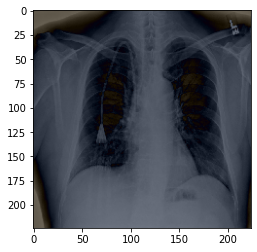

In [ ]:
# preview
import matplotlib.pyplot as plt
plt.imshow(img_data[200])
plt.show()

In [ ]:
num_classes = 1
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [ ]:
labels[:125] = 1
labels[125:] = 0

In [ ]:
names = ['Covid-19','Pneumonia']

In [ ]:
Y = labels

x,y = shuffle(img_data,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

model --> Transfer learning 

In [ ]:
image_input = Input(shape=(224,224,3))

model = VGG16(input_tensor=image_input, include_top = True, weights = 'imagenet')

model.summary()


553467904/553467096 [==============================] - 49s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [ ]:
last_layer = model.get_layer('fc2').output
x = Dense(128, activation='relu', name='fc3')(last_layer)
x = Dense(128, activation='relu', name='fc4')(x)
out = Dense(num_classes, activation = 'sigmoid', name = 'output')(x)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
for layer in custom_vgg_model.layers[:-3]:
    layer.trainable = False

custom_vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

custom_vgg_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Training

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    #tf.keras.callbacks.ModelCheckpoint('classification_model_1.h5', save_best_only=True)
]

In [ ]:
custom_vgg_model.fit(X_train, y_train, batch_size=10, epochs=16, verbose=1, validation_data = (X_test, y_test), callbacks=callbacks)

Train on 562 samples, validate on 63 samples
Epoch 1/16
562/562 [==============================] - 14s 24ms/step - loss: 0.5266 - accuracy: 0.8060 - val_loss: 0.6557 - val_accuracy: 0.7460
Epoch 2/16
562/562 [==============================] - 4s 7ms/step - loss: 0.5001 - accuracy: 0.8007 - val_loss: 0.5984 - val_accuracy: 0.7460
Epoch 3/16
562/562 [==============================] - 4s 7ms/step - loss: 0.4933 - accuracy: 0.8025 - val_loss: 0.6440 - val_accuracy: 0.7460
Epoch 4/16
562/562 [==============================] - 4s 7ms/step - loss: 0.4965 - accuracy: 0.8060 - val_loss: 0.6651 - val_accuracy: 0.7460
Epoch 5/16
562/562 [==============================] - 4s 7ms/step - loss: 0.5017 - accuracy: 0.8043 - val_loss: 0.6141 - val_accuracy: 0.7460
Epoch 6/16
562/562 [==============================] - 4s 7ms/step - loss: 0.4826 - accuracy: 0.8060 - val_loss: 0.6246 - val_accuracy: 0.7460
Epoch 7/16
562/562 [==============================] - 4s 7ms/step - loss: 0.4677 - accuracy: 0.8060 -